---
---
# Лабораторная работа №2. Анализ социальных сетей. Кластеризация текстовых данных со стены Вконтакте

In [1]:
import requests
import datetime
import time
import csv
import time
import re
import os
import codecs
import nltk


from openpyxl import Workbook
from openpyxl.utils import get_column_letter
import pandas as pd
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79992\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**OWNERS_LIST** → ОТКУДА запрашиваем  
**ARGUM_LIST** → ЧТО запрашиваем  

In [3]:
TOKEN_ID = '' # ← Поставь тут твой токен
API_V = '5.126'
#OWNERS_LIST = [-1, -38369814, -142046107, -41669198, -94225164]
OWNERS_LIST = [-1]
ARGUM_LIST = ['id', 'from_id', 'owner_id', 'date', 'text', 'views', 'likes', 'reposts', 'comments']

- ```count``` - количесто постов, которые мы получаем за 1 запрос. Принимает значения от 1 до 100.  
  
- ```offset``` - сдвиг точки отсчёта запроса постов. Чтобы после первых 100 постов запросить следующие 100. Принимает любые целочисленные значения от 0 до бесконечности.  
  
- ```filter_owner``` - Может принимать несколько значений. Мы пока выбираем из двух (str) значений, либо ```owner``` либо ```all```. Где ```all``` - все значения постов, и предлагаемые, и рекламные, и опубликованные. А ```owner``` - опубликованные на стене в данный момент.  
  
- ```group_id``` - айди страницы, с которой собираем посты. Если значение положительное, значит это страница "человека", если отрицательное, значит это паблик\группа.  


Функция которая принимает на вход параметры **owner_id, count, filter_owner, offset**  
совершает ГЕТ запрос на сервер, и возвращает джсон с данными о запрошенном количестве постов  
(количество постов 'count' от 0 до 100):  

In [4]:
def wall_get(owner_id, count, filter_owner, offset):
    try:
        r = requests.get('https://api.vk.com/method/wall.get', params={'owner_id': owner_id,
                                                                       'count': count,
                                                                       'v': API_V,
                                                                       'offset': offset,
                                                                       'filter': filter_owner,
                                                                       'access_token': TOKEN_ID})
    except Exception as err:
        return err
    
    response = r.json()
    return response

Функция, которая принимает на вход group_id = owner_id по модулю (без "-")  
И возвращает количество подписчиков в этой группе, для расчёта ER Post

In [5]:
def folower_count_get(owner_id):
    try:
        rf = requests.get('https://api.vk.com/method/groups.getMembers', params={'group_id': owner_id,
                                                                                 'v': API_V,
                                                                                 'access_token': TOKEN_ID})
    except Exception as err:
        return err
    
    rf_response = rf.json()
    return rf_response['response']['count']

Функция, которая принимает на вход параметры **owner_id, count, filter_owner, offset**  
с которыми обращается к функции **wall_get**, обрабатывает то, что вернула функция **wall_get**  
и, обработав, возвращает Лист, в котором каждый элемент это Словарь, внутри которого данные по всем постам.  
  
На будущее - если захотим делать проверку, собрали ли мы ВСЕ посты, или где-то был сбой,  
можно создать переменную и присвоить ей значение **post_counts = data['response']['count']**  
И сравнивать длинну списка **all_posts** и число в переменной **post_counts**  

In [6]:
def cycle_wall_get(owner_id, count, filter_owner, offset):
    # Объявляем список, внутри которого будем хранить ВСЕ полученные с паблика посты (1 элемент = 1 пост)
    all_posts = [] 
    try:
        while True:
            data = wall_get(owner_id, count, filter_owner, offset)
            items = data['response']['items'] # Получаем список, где каждый элемент - словарь с инфой про посты
            if not items: # Цикл, "пока запрос не вернёт 0 постов - продолжай запрашивать посты"
                break
            all_posts.extend(items) # Записываем полученный отдельным запросом список в общий список постов
            offset += 100
        return all_posts
    except Exception as err:
        return err

Функция **распарсинга**, которая принимает в качестве параметров ключи **views, likes, reposts, comments**  
по которым получает данные каждого поста. Для того, чтобы получить список всех постов,  
присваиваем переменной **all_posts** объект, которой нам возвращает функция **cycle_wall_get()**  
проходим циклом по каждому посту в списке, и в каждой итерации получает словарь с нужными данными по посту.  
Затем вносит полученные **.values()** в итоговый  

In [7]:
def post_keys_values(post, owner_id, count, filter_owner, offset):
    post_dict = {k: post[k]['count'] if k in post and type(post[k]) == dict 
                  else post.setdefault(k, 0) for k in ARGUM_LIST}
    return post_dict

In [8]:
def post_db(owner_id, count, filter_owner, offset):
    # Инициируем словарь, в который будем складывать распарсенные данные
    all_data = {k: [] for k in ARGUM_LIST}
    all_posts = cycle_wall_get(owner_id, count, filter_owner, offset) # Получили список, где каждый элемент - пост
    
    for post in all_posts:       
        d = post_keys_values(post, owner_id, count, filter_owner, offset) # Получили словарь, с данными по посту
        for k in ARGUM_LIST:
            all_data[k].append(d[k])
            
    return all_data

In [9]:
def save_db_csv(owner_id, count, filter_owner, offset):
    all_data = post_db(owner_id, count, filter_owner, offset)
    df = pd.DataFrame.from_dict(all_data, dtype='int64')
    #df['date'] = pd.to_datetime(df['date'], unit='s') # Конвертируем время в датафрейме сразу, до записи в файл
    df.to_csv('vk_wall_get.csv', header=False, mode='a', float_format = '%.0f')
    return df

In [10]:
# Вызываем функцию, передаём в неё необходимые параметры, получаем результат
save_db_csv(-1, 100, 'owner', 0)

,id,from_id,owner_id,date,text,views,likes,reposts,comments
0,399082,-1,-1,1639647000,С гордостью представляем обновлённый портал дл...,39492,197,93,65
1,398704,-1,-1,1633528892,Даём старт грантовой программе Fresh Code от [...,307308,80,26,54
2,398461,-1,-1,1628249546,[https://vk.com/wall-1_394596|Ранее] мы писали...,327007,164,94,102
3,398400,-1,-1,1626865670,Приглашаем встретиться 28 июля на квартальном ...,305816,63,14,29
4,398326,-1,-1,1625675100,Теперь пользователи могут оплачивать внутренню...,307614,82,28,58
...,...,...,...,...,...,...,...,...,...
188,240436,-1,-1,1296906872,Теперь openApi приложения тоже могут использов...,0,144,5,32
189,238413,-1,-1,1296834053,Подключение виджетов в IFrame-приложениях http...,0,103,7,6
190,236533,-1,-1,1296757026,Обновлён метод wall.post для публикации записе...,0,117,8,10
191,55229,-1,-1,1289247197,Результаты второго этапа конкурса на разработк...,0,686,9,27


---
# Получение данных со стены сообщества "СколТех"

In [11]:
owner_id = -34737049
count = 100
filter_owner = 'owner'
offset = 0
views = 'views'
likes = 'likes'
reposts = 'reposts'
comments = 'comments'

In [12]:
# Создаём стартовый ДатаФрейм
df = save_db_csv(owner_id, count, filter_owner, offset)

In [13]:
# Создаём экспериментальный ДатаФрейм на основе стартового, чтобы не навредить стартовому
df2 = df.copy()
df2

,id,from_id,owner_id,date,text,views,likes,reposts,comments
0,11499,-34737049,-34737049,1639060132,⚡ Скоро мы откроем приём заявок в магистратуру...,26378,21,66,0
1,11532,-34737049,-34737049,1639749946,"🧠 Как работает, развивается и стареет мозг? Ес...",1972,13,14,2
2,11531,-34737049,-34737049,1639745121,"🍄 Это Schizophyllum commune — гриб, признанный...",1498,6,4,0
3,11530,-34737049,-34737049,1639736996,Как стартапу оценить рынок в любой стране в лю...,1221,3,1,0
4,11529,-34737049,-34737049,1639667625,⚡ Посвятите вечер четверга науке и энергии буд...,1998,10,5,0
...,...,...,...,...,...,...,...,...,...
4352,5,-34737049,-34737049,1330685961,"""Когда я узнаю, что студент, поступивший и в С...",0,3,0,1
4353,4,-34737049,-34737049,1330679325,"""Лучше тратить деньги на СколковоТех, чем на Р...",0,7,2,0
4354,3,-34737049,-34737049,1330679183,"""Будет нулевая терпимость к любым попыткам дат...",0,4,0,0
4355,2,-34737049,-34737049,1330678549,Хочешь стать одним из первых 20 магистров Скол...,0,6,0,0


Создадим новый столбец со ссылкой на пост

In [14]:
df2['link'] = 'https://vk.com/wall' + str(owner_id) + '_' + df2['id'].map(str)
df2['link']

0       https://vk.com/wall-34737049_11499
1       https://vk.com/wall-34737049_11532
2       https://vk.com/wall-34737049_11531
3       https://vk.com/wall-34737049_11530
4       https://vk.com/wall-34737049_11529
                       ...                
4352        https://vk.com/wall-34737049_5
4353        https://vk.com/wall-34737049_4
4354        https://vk.com/wall-34737049_3
4355        https://vk.com/wall-34737049_2
4356        https://vk.com/wall-34737049_1
Name: link, Length: 4357, dtype: object

И удалим ненужный столбец с id, чтоб не мешался, он своё дело сделал

In [15]:
df2.drop(['id'], axis=1)

,from_id,owner_id,date,text,views,likes,reposts,comments,link
0,-34737049,-34737049,1639060132,⚡ Скоро мы откроем приём заявок в магистратуру...,26378,21,66,0,https://vk.com/wall-34737049_11499
1,-34737049,-34737049,1639749946,"🧠 Как работает, развивается и стареет мозг? Ес...",1972,13,14,2,https://vk.com/wall-34737049_11532
2,-34737049,-34737049,1639745121,"🍄 Это Schizophyllum commune — гриб, признанный...",1498,6,4,0,https://vk.com/wall-34737049_11531
3,-34737049,-34737049,1639736996,Как стартапу оценить рынок в любой стране в лю...,1221,3,1,0,https://vk.com/wall-34737049_11530
4,-34737049,-34737049,1639667625,⚡ Посвятите вечер четверга науке и энергии буд...,1998,10,5,0,https://vk.com/wall-34737049_11529
...,...,...,...,...,...,...,...,...,...
4352,-34737049,-34737049,1330685961,"""Когда я узнаю, что студент, поступивший и в С...",0,3,0,1,https://vk.com/wall-34737049_5
4353,-34737049,-34737049,1330679325,"""Лучше тратить деньги на СколковоТех, чем на Р...",0,7,2,0,https://vk.com/wall-34737049_4
4354,-34737049,-34737049,1330679183,"""Будет нулевая терпимость к любым попыткам дат...",0,4,0,0,https://vk.com/wall-34737049_3
4355,-34737049,-34737049,1330678549,Хочешь стать одним из первых 20 магистров Скол...,0,6,0,0,https://vk.com/wall-34737049_2


---
# Кластеризация

In [16]:
all_wall = df['text']

In [17]:
wordcount={}
for wall in all_wall:
  for word in wall.split():
    if word not in wordcount:
      wordcount[word] = 1
    else:
      wordcount[word] += 1
try:
  for wc in wordcount:
    print(wc, wordcount[wc])
except Exception:
  k=1

⚡ 55
Скоро 9
мы 527
откроем 2
приём 12
заявок 81
в 7438
магистратуру 118
Сколтеха. 199
Но 85
помните, 6
что 1091
перед 62
подачей 1
следует 12
хорошенько 4
подготовиться. 5
И 159
вам 162
этом 233
с 2242
удовольствием 5
поможем. 1
🙂 30
23 49
декабря 99
проведём 30
онлайн 27
первый 85
День 67
открытых 170
дверей 130
и 8948
объясним, 6
как 960
отбираем 1
студентов, 40
устроено 6
обучение 119
Сколтехе, 73
кто 167
преподает 2
университете, 14
какие 163
перспективы 52
открываются 9
выпускниками. 7
Также 71
пройдемся 3
по 1645
всем 64
этапам 5
отбора 28
ответим 23
на 3407
все 309
ваши 41
вопросы. 31
📢 23
Не 128
забудьте 74
зарегистрироваться: 51
https://vk.cc/c8QlC5 1
🧠 22
Как 286
работает, 3
развивается 7
стареет 2
мозг? 5
Есть 33
ли 309
разница 7
между 112
мозгом 4
мужчин 2
женщин 12
почему 120
считать 5
его 300
компьютером 1
— 1315
неправильно? 1
Ответ 6
эти 130
вопросы 155
можно 444
найти 88
подкастах 1
Филиппа 18
Хайтовича, 3
которые 396
учёный 14
записал 3
специально 18
для 1402
[club24

In [18]:
print(str(len(all_wall)) + ' запросов считано')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

4357 запросов считано


In [19]:
def token_and_stem(text):
  tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []
  for token in tokens:
    if re.search('[а-яА-Я]', token):
      filtered_tokens.append(token)
  stems = [stemmer.stem(t) for t in filtered_tokens]
  return stems

In [20]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79992\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
def token_only(text):
  tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []
  for token in tokens:
    if re.search('[а-яА-Я]', token):
      filtered_tokens.append(token)
  return filtered_tokens

In [22]:
#Создаем словари (массивы) из полученных основ
totalvocab_stem = []
totalvocab_token = []
for i in all_wall:
  allwords_stemmed = token_and_stem(i)
  #print(allwords_stemmed)
  totalvocab_stem.extend(allwords_stemmed)
  allwords_tokenized = token_only(i)
  totalvocab_token.extend(allwords_tokenized)

nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('russian')

stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79992\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
totalvocab_token

['скоро',
 'мы',
 'откроем',
 'приём',
 'заявок',
 'в',
 'магистратуру',
 'сколтеха',
 'но',
 'помните',
 'что',
 'перед',
 'подачей',
 'следует',
 'хорошенько',
 'подготовиться',
 'и',
 'мы',
 'вам',
 'в',
 'этом',
 'с',
 'удовольствием',
 'поможем',
 'декабря',
 'мы',
 'проведём',
 'онлайн',
 'первый',
 'день',
 'открытых',
 'дверей',
 'и',
 'объясним',
 'как',
 'отбираем',
 'студентов',
 'как',
 'устроено',
 'обучение',
 'в',
 'сколтехе',
 'кто',
 'преподает',
 'в',
 'университете',
 'какие',
 'перспективы',
 'открываются',
 'перед',
 'выпускниками',
 'также',
 'пройдемся',
 'по',
 'всем',
 'этапам',
 'отбора',
 'и',
 'ответим',
 'на',
 'все',
 'ваши',
 'вопросы',
 'не',
 'забудьте',
 'зарегистрироваться',
 'как',
 'работает',
 'развивается',
 'и',
 'стареет',
 'мозг',
 'есть',
 'ли',
 'разница',
 'между',
 'мозгом',
 'мужчин',
 'и',
 'женщин',
 'и',
 'почему',
 'считать',
 'его',
 'компьютером',
 'неправильно',
 'ответ',
 'на',
 'эти',
 'вопросы',
 'можно',
 'найти',
 'в',
 'подкас

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


n_featur=200000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                    max_features=10000,
                                    min_df=0.01,
                                    stop_words=stopwords,
                                    use_idf=True,
                                    tokenizer=token_and_stem, ngram_range=(1,3))
                                    
tfidf_matrix = tfidf_vectorizer.fit_transform(all_wall)
print(tfidf_matrix.shape)

c:\python38\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['бол', 'больш', 'будт', 'быт', 'вед', 'впроч', 'всег', 'всегд', 'даж', 'друг', 'е', 'ег', 'ем', 'есл', 'ест', 'ещ', 'зач', 'зде', 'ил', 'иногд', 'когд', 'конечн', 'куд', 'лучш', 'межд', 'мен', 'мног', 'мо', 'можн', 'нег', 'нельз', 'нибуд', 'никогд', 'нич', 'опя', 'посл', 'пот', 'почт', 'разв', 'сво', 'себ', 'совс', 'теб', 'тепер', 'тог', 'тогд', 'тож', 'тольк', 'хорош', 'хот', 'чег', 'чут', 'эт'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(4357, 723)


In [25]:
num_clusters = 5
# Метод к-средних - KMeans
from sklearn.cluster import KMeans

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
print(clusters)
print (km.labels_)

[1, 0, 4, 2, 0, 1, 3, 3, 1, 3, 4, 2, 1, 3, 3, 4, 4, 4, 3, 4, 4, 4, 2, 0, 0, 4, 4, 0, 4, 4, 4, 2, 4, 0, 2, 0, 2, 4, 0, 3, 4, 3, 3, 0, 4, 0, 3, 0, 3, 3, 4, 4, 0, 3, 4, 4, 0, 0, 0, 3, 0, 2, 4, 2, 2, 3, 4, 3, 0, 4, 4, 4, 4, 2, 4, 4, 3, 4, 3, 4, 3, 2, 0, 4, 4, 4, 3, 4, 3, 4, 4, 4, 0, 4, 0, 4, 3, 3, 4, 3, 4, 0, 4, 0, 3, 1, 4, 2, 2, 3, 3, 4, 4, 0, 4, 4, 2, 4, 3, 4, 4, 2, 4, 3, 3, 3, 3, 2, 4, 2, 4, 4, 0, 4, 4, 1, 4, 3, 4, 4, 2, 3, 4, 0, 0, 4, 3, 4, 3, 3, 2, 0, 2, 0, 2, 3, 4, 4, 3, 4, 0, 4, 4, 0, 0, 3, 3, 2, 4, 4, 4, 3, 0, 2, 0, 0, 2, 2, 2, 3, 2, 4, 0, 4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 3, 2, 3, 3, 3, 3, 4, 4, 3, 3, 0, 0, 2, 4, 3, 3, 4, 2, 4, 2, 2, 2, 3, 2, 2, 3, 1, 3, 0, 4, 3, 0, 4, 4, 3, 0, 4, 4, 4, 0, 4, 3, 4, 0, 0, 3, 4, 2, 4, 4, 0, 4, 2, 2, 4, 2, 4, 4, 0, 4, 4, 0, 4, 0, 0, 4, 0, 4, 2, 4, 4, 4, 1, 4, 2, 3, 2, 4, 0, 4, 0, 0, 4, 4, 0, 2, 4, 2, 4, 4, 4, 1, 4, 4, 0, 2, 2, 1, 4, 1, 4, 2, 1, 1, 4, 0, 2, 4, 1, 4, 0, 1, 4, 2, 1, 0, 2, 4, 1, 4, 4, 1, 0, 4, 4, 2, 3, 2, 2, 1, 0, 3, 2, 4, 3, 1, 3, 2, 4, 4, 

In [26]:
# MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(init='random', n_clusters=num_clusters) 
mbk.fit_transform(tfidf_matrix)
mbk.fit(tfidf_matrix)
miniclusters = mbk.labels_.tolist()
print(mbk.labels_)

[4 4 4 ... 0 4 4]


In [27]:
# DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(tfidf_matrix)
labels = db.labels_
labels.shape
print(labels)

[-1 -1 -1 ... -1 -1 -1]


In [28]:
# Аггломеративная класстеризация
from sklearn.cluster import AgglomerativeClustering
agglo1 = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean') 
answer = agglo1.fit_predict(tfidf_matrix.toarray())
answer.shape

#k-means
clusterkm = km.labels_.tolist()
#minikmeans
clustermbk = mbk.labels_.tolist()
#dbscan
clusters3 = labels
#agglo
#clusters4 = answer.tolist()
frame = pd.DataFrame(all_wall, index = [clusterkm])
#k-means
out = { 'title': all_wall, 'cluster': clusterkm }
frame1 = pd.DataFrame(out, index = [clusterkm],
columns = ['title', 'cluster'])
#mini
out = { 'title': all_wall, 'cluster': clustermbk }
frame_minik = pd.DataFrame(out, index =
[clustermbk], columns = ['title', 'cluster'])
frame1['cluster'].value_counts()
frame_minik['cluster'].value_counts()

4    3799
0     553
1       3
3       1
2       1
Name: cluster, dtype: int64

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)
dist.shape

(4357, 4357)

In [30]:
# Метод главных компонент - PCA
from sklearn.decomposition import IncrementalPCA

icpa = IncrementalPCA(n_components=2, batch_size=16)
icpa.fit(dist)
demo2 = icpa.transform(dist)
xs, ys = demo2[:, 0], demo2[:, 1]

In [31]:
from sklearn.decomposition import IncrementalPCA
icpa = IncrementalPCA(n_components=3, batch_size=16)
icpa.fit(dist)
ddd = icpa.transform(dist)
xs, ys, zs = ddd[:, 0], ddd[:, 1], ddd[:, 2]

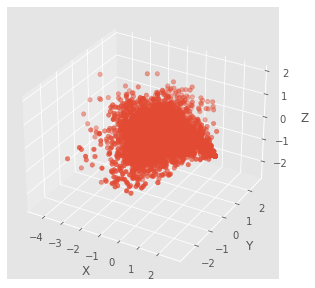

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## Строим WordCloud

In [33]:
from spacy.lang.ru.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
def remove_stopwords(tokens):
    stoplist = list(STOP_WORDS) + list(punctuation) +list(stopwords)
    return [t for t in tokens if t not in stoplist]

counter = Counter(remove_stopwords(totalvocab_token))
counter

Counter({'скоро': 47,
         'откроем': 3,
         'приём': 15,
         'заявок': 92,
         'магистратуру': 141,
         'сколтеха': 2606,
         'помните': 16,
         'подачей': 1,
         'следует': 12,
         'хорошенько': 4,
         'подготовиться': 17,
         'удовольствием': 5,
         'поможем': 7,
         'декабря': 134,
         'проведём': 30,
         'онлайн': 53,
         'первый': 122,
         'день': 291,
         'открытых': 174,
         'дверей': 159,
         'объясним': 10,
         'отбираем': 1,
         'студентов': 278,
         'устроено': 8,
         'обучение': 155,
         'сколтехе': 514,
         'преподает': 2,
         'университете': 89,
         'какие': 218,
         'перспективы': 64,
         'открываются': 9,
         'выпускниками': 15,
         'также': 480,
         'пройдемся': 3,
         'этапам': 5,
         'отбора': 43,
         'ответим': 30,
         'ваши': 46,
         'вопросы': 237,
         'забудьте': 81,
    

<AxesSubplot:xlabel='token'>

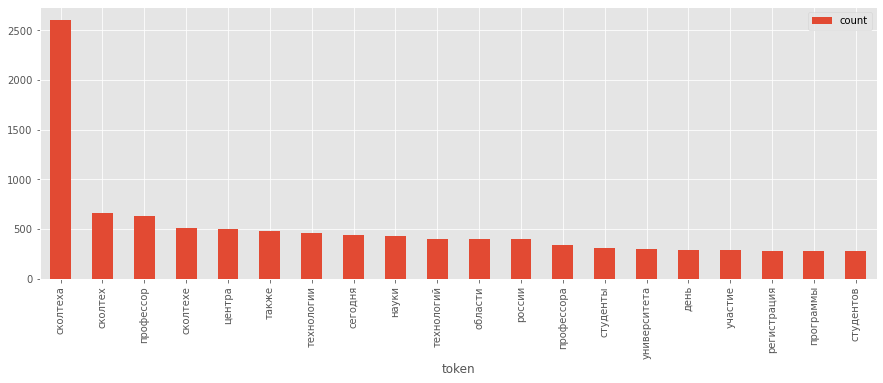

In [34]:
import pandas as pd

freq_df = pd.DataFrame.from_records(counter.most_common(20), columns = ['token', 'count'])

freq_df.plot(kind='bar', x='token')

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordlcloud(counter):
    wc = WordCloud(width=1200, height=800,
                  background_color='white',
                  max_words = 200)
    wc.generate_from_frequencies(counter)
    
    fig=plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

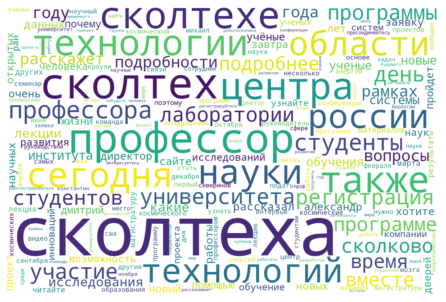

In [36]:
wordlcloud(counter)